In [86]:
import json
import pystac
import rioxarray
import geopandas as gpd
from pystac_client import Client
import numpy as np
import xarray
import rasterio

import earthpy.plot as ep
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

----

<Axes: >

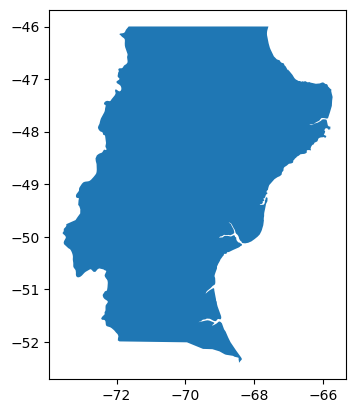

In [3]:
country = "Argentina"
province = "Santa Cruz"

provinces = gpd.read_file("./data/states_provinces/ne_10m_admin_1_states_provinces.shp")
# Find Santa Cruz in the dataset
scdf = provinces.loc[(provinces['name'] == province) & (provinces['admin'] == country)]
scdf = scdf.reset_index(drop=True)
scdf.plot()

In [4]:
scdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
santa_cruz_dict = scdf.iloc[0].geometry.__geo_interface__
santa_cruz_polygon = json.dumps(santa_cruz_dict)

----

## Get Raster Data

In [10]:
api_url = "https://earth-search.aws.element84.com/v1"
client = Client.open(api_url)
collection = "sentinel-2-l2a"  # Sentinel-2, Level 2A, Cloud Optimized GeoTiffs (COGs)

In [11]:
search = client.search(
    collections=[collection],
    intersects=santa_cruz_polygon,
    #max_items=10,
    datetime="2020-11-01/2020-12-01",
    query=["eo:cloud_cover<20"]
)
print(search.matched())

236


In [15]:
items = search.item_collection()

In [56]:
item = items[6]
print(item.datetime)
print(item.geometry)
print(item.properties)

2020-12-01 14:45:31.577000+00:00
{'type': 'Polygon', 'coordinates': [[[-71.54310319009136, -45.124983266555944], [-70.53542559832184, -45.14298389050848], [-70.87369353583719, -46.12622850047145], [-71.5881610415898, -46.11227722229626], [-71.54310319009136, -45.124983266555944]]]}
{'created': '2022-11-06T11:30:21.821Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 10.58866, 'proj:epsg': 32719, 'mgrs:utm_zone': 19, 'mgrs:latitude_band': 'G', 'mgrs:grid_square': 'CK', 'grid:code': 'MGRS-19GCK', 'view:sun_azimuth': 51.6317528330401, 'view:sun_elevation': 57.7833822764969, 's2:degraded_msi_data_percentage': 0, 's2:nodata_pixel_percentage': 38.639152, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 3.833089, 's2:cloud_shadow_percentage': 0.115214, 's2:vegetation_percentage': 6.487378, 's2:not_vegetated_percentage': 74.76092, 's2:water_percentage': 0.130938, 's2:unclassified_percentage': 4.053202, 's2:medium

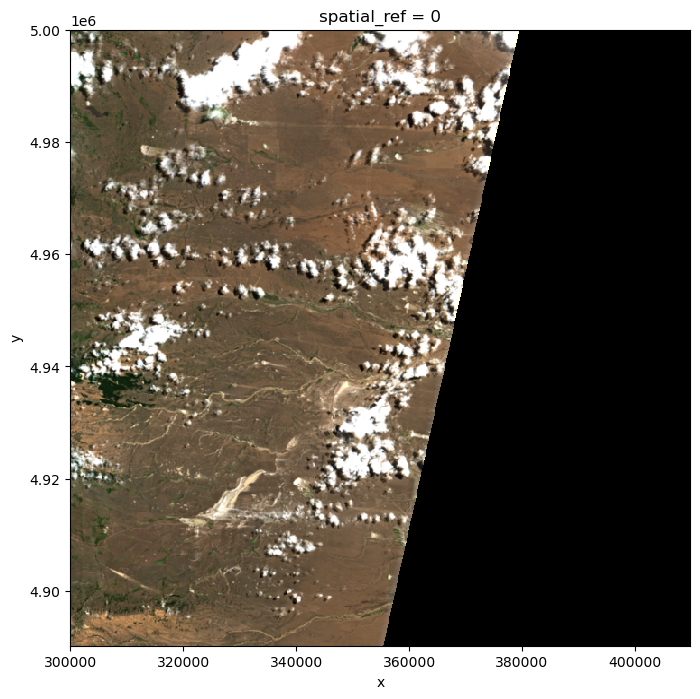

In [78]:
raster_overview = rioxarray.open_rasterio(item.assets["visual"].href, overview_level=3)
raster_overview.plot.imshow(figsize=(8,8))

In [59]:
red_uri = item.assets["red"].href
nir_uri = item.assets["nir08"].href

In [60]:
red = rioxarray.open_rasterio(red_uri, masked=True)
nir = rioxarray.open_rasterio(nir_uri, masked=True)

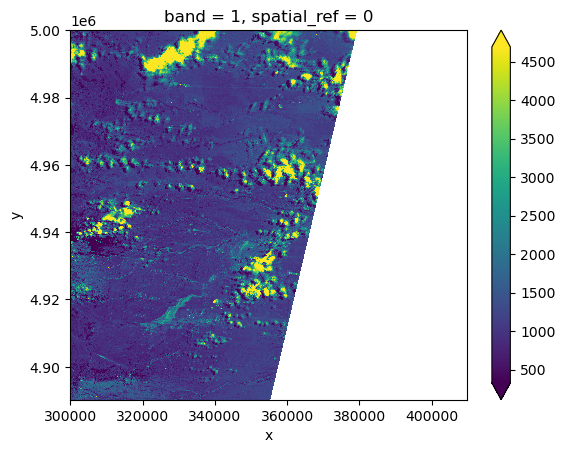

In [61]:
red.plot(robust=True)

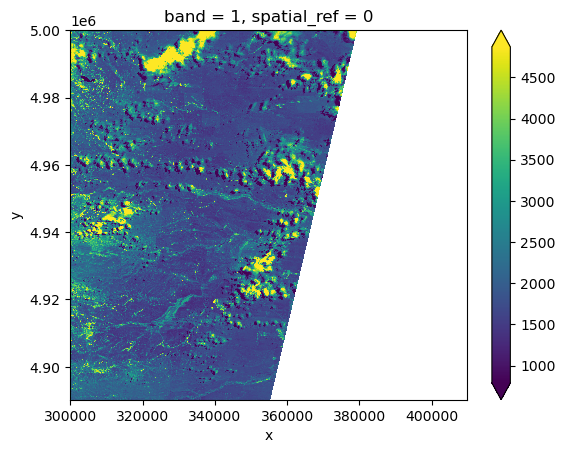

In [62]:
nir.plot(robust=True)

In [63]:
print(red.shape, nir.shape)

(1, 10980, 10980) (1, 5490, 5490)


In [64]:
red_matched = red.rio.reproject_match(nir)
print(red_matched.shape)

(1, 5490, 5490)


In [65]:
ndvi = (nir - red_matched)/ (nir + red_matched)
ndvi

<xarray.DataArray (band: 1, y: 5490, x: 5490)>
array([[[0.49801475, 0.43125346, 0.6542793 , ...,        nan,
                nan,        nan],
        [0.5390266 , 0.63128096, 0.587363  , ...,        nan,
                nan,        nan],
        [0.7192871 , 0.62980133, 0.5734628 , ...,        nan,
                nan,        nan],
        ...,
        [0.19466074, 0.3746755 , 0.29149377, ...,        nan,
                nan,        nan],
        [0.5245428 , 0.45560408, 0.280022  , ...,        nan,
                nan,        nan],
        [0.525393  , 0.2926412 , 0.28984615, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05 4.098e+05
  * y            (y) float64 5e+06 5e+06 5e+06 ... 4.89e+06 4.89e+06 4.89e+06
    spatial_ref  int64 0

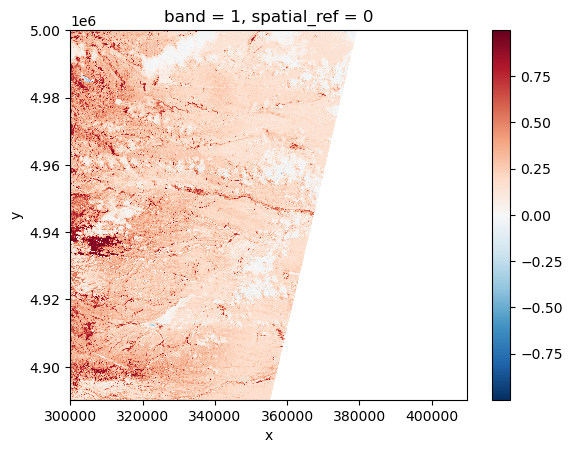

In [66]:
ndvi.plot()

(array([2.0000000e+01, 4.1000000e+02, 9.9210000e+03, 1.1414000e+05,
        2.9478060e+06, 1.0867943e+07, 3.2249090e+06, 7.4882500e+05,
        3.8870700e+05, 1.9154000e+05]),
 array([-0.75666666, -0.58105016, -0.4054336 , -0.22981708, -0.05420055,
         0.12141597,  0.29703251,  0.47264904,  0.64826554,  0.8238821 ,
         0.99949861]),
 <BarContainer object of 10 artists>)

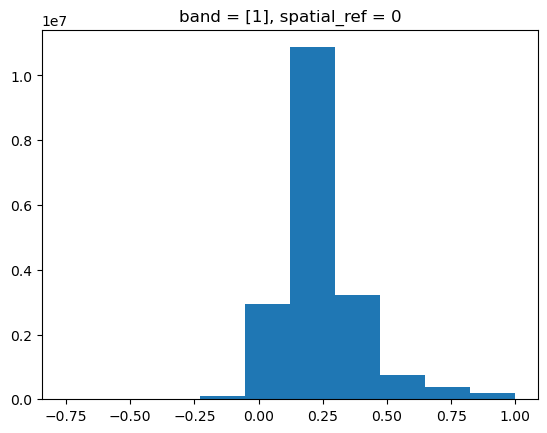

In [67]:
ndvi.plot.hist()

In [68]:
print(ndvi.min().values)
print(ndvi.max().values)
print(ndvi.isnull().sum().values)

-0.7566666603088379
0.9994986057281494
11645879


(array([1.000000e+00, 0.000000e+00, 4.000000e+00, 7.000000e+00,
        8.000000e+00, 2.300000e+01, 4.300000e+01, 5.900000e+01,
        1.070000e+02, 1.780000e+02, 4.260000e+02, 8.360000e+02,
        2.349000e+03, 3.057000e+03, 3.253000e+03, 4.465000e+03,
        6.510000e+03, 1.134100e+04, 2.462900e+04, 6.719500e+04,
        2.380900e+05, 4.980970e+05, 5.735090e+05, 6.697120e+05,
        9.683980e+05, 1.899541e+06, 2.733540e+06, 2.623195e+06,
        2.079367e+06, 1.532300e+06, 1.132805e+06, 8.150420e+05,
        5.770140e+05, 4.075950e+05, 2.924530e+05, 2.197080e+05,
        1.721500e+05, 1.397940e+05, 1.161180e+05, 1.010550e+05,
        9.181500e+04, 8.504100e+04, 7.737700e+04, 7.130700e+04,
        6.316700e+04, 5.370200e+04, 4.486900e+04, 4.852100e+04,
        3.822700e+04, 6.221000e+03]),
 array([-0.75666666, -0.72154337, -0.68642002, -0.65129673, -0.61617345,
        -0.58105016, -0.54592681, -0.51080352, -0.47568023, -0.44055691,
        -0.4054336 , -0.37031031, -0.33518699, -

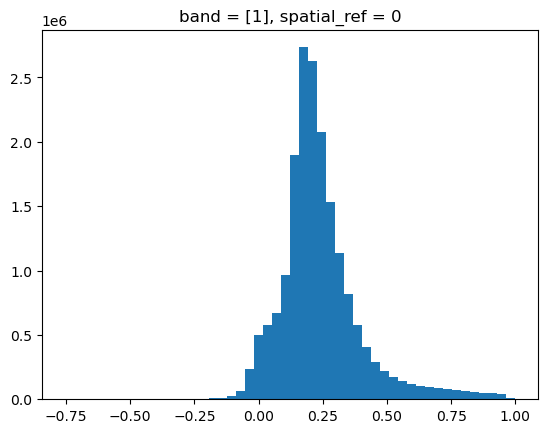

In [69]:
ndvi.plot.hist(bins=50)

- −1 <= NDVI < 0 for water;
- 0 <= NDVI < 0.2 for no vegetation;
- 0.2 <= NDVI < 0.7 for sparse vegetation;
- 0.7 <= NDVI < 1 for dense vegetation.

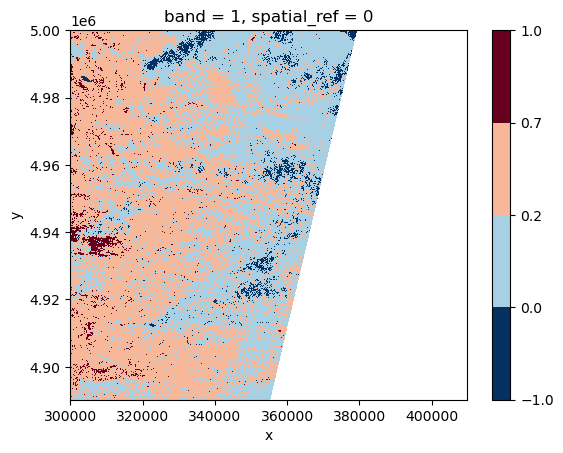

In [70]:
class_bins = (-1, 0., 0.2, 0.7, 1)
ndvi.plot(levels=class_bins)

In [71]:
ndvi_nonan = ndvi.interpolate_na(dim="x")

## Classifying

In [72]:
class_bins = (-1, 0., 0.2, 0.7, 1)

# The numpy.digitize function returns an unlabeled array, in this case, a
# classified array without any metadata. That doesn't work--we need the
# coordinates and other spatial metadata. We can get around this using
# xarray.apply_ufunc, which can run the function across the data array while
# preserving metadata.
ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    class_bins
)

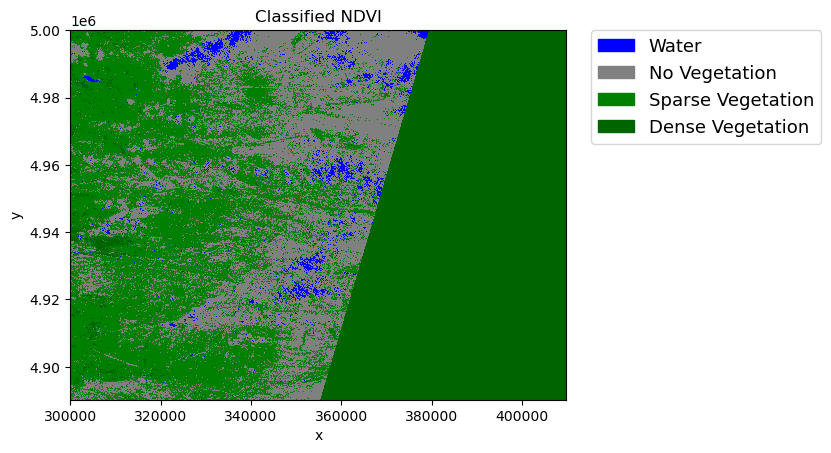

In [73]:
# Define color map of the map legend
ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

# Define class names for the legend
category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

# We need to know in what order the legend items should be arranged
category_indices = list(range(len(category_names)))

# Make the plot
im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")
# earthpy helps us by drawing a legend given an existing image plot and legend items, plus indices
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)

# # Save the figure
# plt.savefig("NDVI_classified.png", bbox_inches="tight", dpi=300)

In [74]:
ndvi_classified.rio.to_raster("NDVI_classified.tif", dtype="int32")